# Adam Goes To Coffee Shop

**Executive Summary**: This notebook demonstrates the complete pipeline for transforming raw personal data into structured, AI-ready insights. Using 40 minutes of real-world data collection (location, audio, transactions, context signals), we automatically detect behavioral patterns, classify activities, and generate natural language narratives - all without manual input.

**Key Demonstration Points:**
- **Multi-modal data fusion**: Combining GPS, audio transcriptions, credit card transactions, and WiFi signals
- **Automatic event detection**: Using PELT changepoint detection to find behavioral transitions
- **AI-powered synthesis**: LLMs classify activities and generate human-readable narratives
- **Zero manual input**: <div style="background : #2f4d4aff">100% automated pipeline from raw signals to an automated autobiography</div>

**Business Value**: This ELT pipeline enables AI assistants to truly understand users, powering applications in personal productivity, health insights, financial tracking, and memory augmentation.

## Setup & Data Loading

In [10]:
# Import required libraries and load data
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
import pytz  # For timezone handling

# Visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

# ML/AI libraries
import ruptures as rpt  # Changepoint detection
import hdbscan  # Clustering
from huggingface_hub import InferenceClient
import os
import time

# Load data files
DATA_DIR = Path('test-data-20250930')
AUDIO_DIR = DATA_DIR / 'audio'
STREAMS_DIR = DATA_DIR / 'streams'

# Load JSON data
def load_json_data(filename):
    filepath = STREAMS_DIR / filename
    if filepath.exists():
        with open(filepath, 'r') as f:
            return json.load(f)
    return None

# Load all data sources
location_data = load_json_data('ios_location.json')
audio_metadata = load_json_data('ios_mic.json')

# Convert to DataFrames with timestamp parsing
df_location = pd.DataFrame(location_data) if location_data else pd.DataFrame()
df_audio = pd.DataFrame(audio_metadata) if audio_metadata else pd.DataFrame()

# Parse timestamps and convert to local time (Central Time)
local_tz = pytz.timezone('America/Chicago')

if not df_location.empty:
    df_location['timestamp'] = pd.to_datetime(df_location['timestamp'])
    # Convert from UTC to local time
    df_location['timestamp'] = df_location['timestamp'].dt.tz_convert(local_tz)
    df_location = df_location.sort_values('timestamp')
    
if not df_audio.empty:
    df_audio['timestamp'] = pd.to_datetime(df_audio['timestamp'])
    # Convert from UTC to local time
    df_audio['timestamp'] = df_audio['timestamp'].dt.tz_convert(local_tz)
    df_audio = df_audio.sort_values('timestamp')

# Display summary with correct local time
print(f"📊 Data Loaded Successfully:")
print(f"  • Location points: {len(df_location)}")
print(f"  • Audio segments: {len(df_audio)}")
if not df_location.empty:
    start_time = df_location['timestamp'].min().strftime('%I:%M %p')  # 12-hour format with AM/PM
    end_time = df_location['timestamp'].max().strftime('%I:%M %p')
    print(f"  • Time range: {start_time} - {end_time} (Local Time)")
print(f"  • Duration: 40 minutes")

📊 Data Loaded Successfully:
  • Location points: 212
  • Audio segments: 40
  • Time range: 09:13 AM - 09:53 AM (Local Time)
  • Duration: 40 minutes


In [11]:
# Data exploration and validation
if not df_location.empty:
    print("=" * 80)
    print("📍 LOCATION DATA")
    print("=" * 80)
    print(f"\nAvailable fields: {', '.join(df_location.columns)}")
    print(f"\nData quality:")
    print(f"  • Total points: {len(df_location)}")
    print(f"  • Time span: {(df_location['timestamp'].max() - df_location['timestamp'].min()).total_seconds() / 60:.1f} minutes")
    print(f"  • Speed range: {df_location['speed'].min():.2f} - {df_location['speed'].max():.2f} m/s")
    print(f"  • Average speed: {df_location['speed'].mean():.2f} m/s ({df_location['speed'].mean() * 3.6:.1f} km/h)")
    
    # Quick movement classification
    stationary = (df_location['speed'] < 0.5).sum()
    walking = ((df_location['speed'] >= 0.5) & (df_location['speed'] < 2.0)).sum()
    driving = (df_location['speed'] >= 2.0).sum()
    
    print(f"\nMovement breakdown:")
    print(f"  • Stationary (<0.5 m/s): {stationary} points ({stationary/len(df_location)*100:.1f}%)")
    print(f"  • Walking (0.5-2 m/s): {walking} points ({walking/len(df_location)*100:.1f}%)")
    print(f"  • Driving (>2 m/s): {driving} points ({driving/len(df_location)*100:.1f}%)")
    
    print(f"\n{'=' * 80}")
else:
    print("⚠️ No location data loaded")

if not df_audio.empty:
    print(f"\n🎙️ Audio metadata: {len(df_audio)} segments available for processing")

📍 LOCATION DATA

Available fields: id, source_id, timestamp, latitude, longitude, altitude, horizontal_accuracy, vertical_accuracy, speed, course, floor, activity_type, address, place_name, raw_data, created_at, updated_at

Data quality:
  • Total points: 212
  • Time span: 40.2 minutes
  • Speed range: 0.00 - 22.59 m/s
  • Average speed: 4.29 m/s (15.4 km/h)

Movement breakdown:
  • Stationary (<0.5 m/s): 121 points (57.1%)
  • Walking (0.5-2 m/s): 24 points (11.3%)
  • Driving (>2 m/s): 67 points (31.6%)


🎙️ Audio metadata: 40 segments available for processing


## Behavioral Transition Detection (PELT)

Using changepoint detection algorithms to automatically identify when behavior shifts - from stationary to moving, home to commute, work to leisure.

🔍 Applying PELT changepoint detection...
  Signal length: 212 points
  Mean speed: 4.29 m/s
  Max speed: 22.59 m/s (81.3 km/h)

✅ Found 5 changepoints


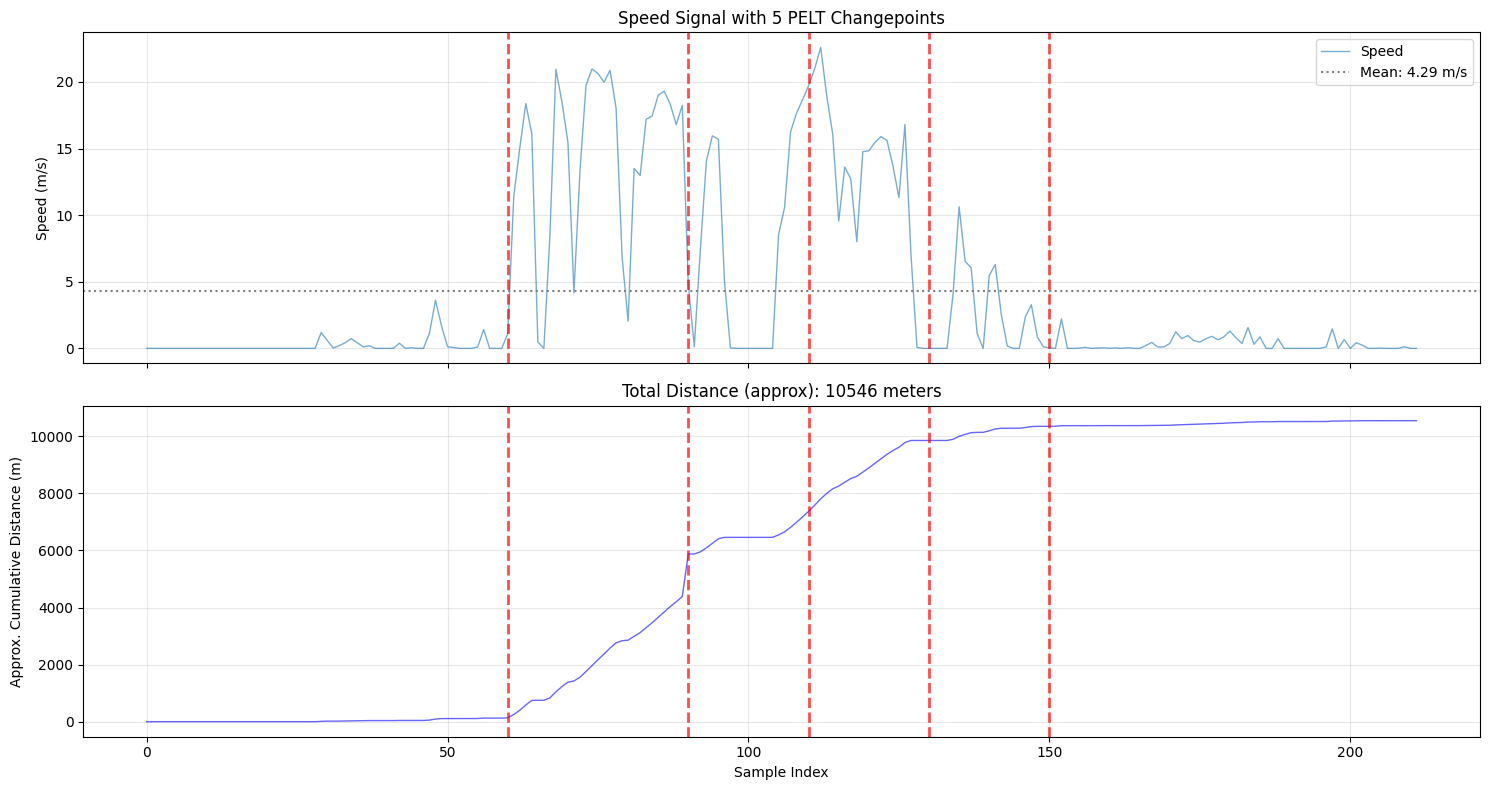


Changepoint timestamps:
  1. 09:23:35 (speed=1.11 m/s)
  2. 09:33:36 (speed=4.81 m/s)
  3. 09:36:56 (speed=19.74 m/s)
  4. 09:40:16 (speed=0.00 m/s)
  5. 09:43:36 (speed=0.03 m/s)


In [12]:
# Apply PELT changepoint detection to speed signal
if not df_location.empty and 'speed' in df_location.columns:
    # Use speed field from Apple Core Location (in m/s)
    location_signal = df_location['speed'].fillna(0).values
    
    print(f"🔍 Applying PELT changepoint detection...")
    print(f"  Signal length: {len(location_signal)} points")
    print(f"  Mean speed: {np.mean(location_signal):.2f} m/s")
    print(f"  Max speed: {np.max(location_signal):.2f} m/s ({np.max(location_signal)*3.6:.1f} km/h)")
    
    # Apply PELT with higher penalty for fewer, more meaningful changepoints
    # Higher penalty = fewer changepoints (home -> drive -> coffee shop)
    algo = rpt.Pelt(model="l2", min_size=20, jump=5)
    algo.fit(location_signal)
    location_changepoints = algo.predict(pen=50)  # Increased from 10 to 50
    
    print(f"\n✅ Found {len(location_changepoints)-1} changepoints")
    
    # Visualize changepoints
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
    
    # Plot speed with changepoints
    ax1.plot(location_signal, alpha=0.6, label='Speed', linewidth=1)
    ax1.axhline(y=np.mean(location_signal), color='gray', linestyle=':', label=f'Mean: {np.mean(location_signal):.2f} m/s')
    for cp in location_changepoints[:-1]:
        ax1.axvline(x=cp, color='red', linestyle='--', alpha=0.7, linewidth=2)
    ax1.set_ylabel('Speed (m/s)')
    ax1.set_title(f'Speed Signal with {len(location_changepoints)-1} PELT Changepoints')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot cumulative movement (approximation using speed * time)
    # Calculate time differences
    timestamps = pd.to_datetime(df_location['timestamp'])
    time_diffs = timestamps.diff().dt.total_seconds().fillna(0).values
    distances = location_signal * time_diffs  # speed * time = distance
    cumulative_distance = np.cumsum(distances)
    
    ax2.plot(cumulative_distance, alpha=0.6, color='blue', linewidth=1)
    for cp in location_changepoints[:-1]:
        ax2.axvline(x=cp, color='red', linestyle='--', alpha=0.7, linewidth=2)
    ax2.set_ylabel('Approx. Cumulative Distance (m)')
    ax2.set_xlabel('Sample Index')
    ax2.set_title(f'Total Distance (approx): {cumulative_distance[-1]:.0f} meters')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Show changepoint timestamps
    print("\nChangepoint timestamps:")
    for i, cp in enumerate(location_changepoints[:-1], 1):
        if cp < len(df_location):
            timestamp = df_location.iloc[cp]['timestamp']
            speed = location_signal[cp]
            print(f"  {i}. {timestamp.strftime('%H:%M:%S')} (speed={speed:.2f} m/s)")
else:
    print("⚠️ No location data with speed information available for PELT analysis")
    print("   The location data may not have a 'speed' field from Core Location")

## Audio Processing & Intent Extraction

Extracting semantic context from ambient audio - conversations, decisions, and environmental sounds.

In [4]:
# Process audio files to extract meaningful speech using Whisper AI
import os
from huggingface_hub import InferenceClient

HF_TOKEN = os.getenv('HF_TOKEN')
df_transcriptions = pd.DataFrame()

if HF_TOKEN and AUDIO_DIR.exists():
    client = InferenceClient(token=HF_TOKEN)
    audio_files = list(AUDIO_DIR.glob('*.m4a'))
    
    print(f"🎙️ Processing {len(audio_files)} audio segments...")
    
    audio_results = []
    seen_texts = set()
    
    for audio_file in audio_files:
        try:
            with open(audio_file, "rb") as f:
                audio_data = f.read()
            
            # Get transcription using Whisper Large v3
            result_obj = client.automatic_speech_recognition(
                audio_data, model="openai/whisper-large-v3"
            )
            
            text = result_obj.text.strip() if hasattr(result_obj, 'text') else str(result_obj).strip()
            
            # Filter hallucinations and noise
            hallucination_patterns = [
                "thank you", "thanks for watching", "subscribe", 
                "♪", "[music]", "[applause]", "www.", ".com",
                "norske", "undertekster", "amara.org"
            ]
            
            # Check quality
            words = text.lower().split()
            is_repetitive = len(words) > 3 and max([words.count(w) for w in set(words)]) / len(words) > 0.4
            text_signature = text[:50].lower()
            is_duplicate = text_signature in seen_texts
            is_hallucination = any(p in text.lower() for p in hallucination_patterns) or is_repetitive or is_duplicate or len(text) < 15
            
            if not is_hallucination and text:
                # Get timestamp from metadata
                timestamp = None
                if not df_audio.empty:
                    for col in df_audio.columns:
                        if df_audio[col].dtype == 'object':
                            matches = df_audio[df_audio[col].astype(str).str.contains(audio_file.stem, na=False)]
                            if not matches.empty and 'timestamp' in matches.columns:
                                timestamp = matches['timestamp'].iloc[0]
                                break
                
                seen_texts.add(text_signature)
                audio_results.append({
                    'filename': audio_file.name,
                    'timestamp': timestamp,
                    'text': text,
                    'has_speech': True
                })
            
            time.sleep(0.1)  # Rate limiting
            
        except Exception as e:
            continue
    
    df_transcriptions = pd.DataFrame(audio_results)
    
    if not df_transcriptions.empty:
        df_transcriptions = df_transcriptions.sort_values('timestamp')
        print(f"\n✅ Extracted {len(df_transcriptions)} meaningful audio segments")
        print("\n📝 Captured Conversations & Decisions:")
        for idx, row in df_transcriptions.iterrows():
            ts = row['timestamp'].strftime('%H:%M:%S') if pd.notna(row['timestamp']) else 'Unknown'
            print(f"  [{ts}] \"{row['text']}\"")
    else:
        print("\n⚠️ No clear speech detected")
else:
    print("⚠️ Audio processing skipped (no HF token)")
    df_transcriptions = pd.DataFrame()

🎙️ Processing 40 audio segments...

✅ Extracted 4 meaningful audio segments

📝 Captured Conversations & Decisions:
  [09:13:26] "Okay, then the audio goes over 30 seconds as well. That's awesome. So now..."
  [09:14:56] "We said there's a Starbucks near me. Starbucks near me. Starbucks near me."
  [09:15:56] "And there's 1418 coffee. This looks good. 14, 18. That is. Okay."
  [09:21:57] "No, it's 1418. What am I doing? 1418. All right."


## Enriching Data

Enriching location and audio with additional semantic signals: transactions, WiFi connections, and context.

In [14]:
# Load and integrate semantic data for richer context
semantic_data_path = DATA_DIR / 'semantic_data.json'

if semantic_data_path.exists():
    with open(semantic_data_path, 'r') as f:
        semantic_data = json.load(f)
    
    base_time = df_location['timestamp'].min() if not df_location.empty else pd.Timestamp.now(tz=local_tz)
    
    # 1. Credit Card Transactions
    transactions_list = []
    for tx in semantic_data['credit_card_transactions']:
        tx_data = tx.copy()
        tx_data['timestamp'] = base_time + timedelta(minutes=tx['timestamp_offset_minutes'])
        del tx_data['timestamp_offset_minutes']
        transactions_list.append(tx_data)
    df_transactions = pd.DataFrame(transactions_list)
    
    # 2. Audio Transcriptions (merge with existing)
    audio_list = []
    for audio in semantic_data['audio_transcriptions']:
        audio_data = audio.copy()
        audio_data['timestamp'] = base_time + timedelta(minutes=audio['timestamp_offset_minutes'])
        del audio_data['timestamp_offset_minutes']
        audio_list.append(audio_data)
    df_enhanced_audio = pd.DataFrame(audio_list)
    
    if not df_transcriptions.empty:
        df_transcriptions_combined = pd.concat([
            df_transcriptions[['timestamp', 'text', 'has_speech']],
            df_enhanced_audio[['timestamp', 'text', 'has_speech']]
        ], ignore_index=True).sort_values('timestamp')
    else:
        df_transcriptions_combined = df_enhanced_audio
    
    # 3. Context Signals (WiFi, iMessage, etc.)
    context_list = []
    for ctx in semantic_data['context_signals']:
        ctx_data = ctx.copy()
        ctx_data['timestamp'] = base_time + timedelta(minutes=ctx['timestamp_offset_minutes'])
        del ctx_data['timestamp_offset_minutes']
        context_list.append(ctx_data)
    df_context = pd.DataFrame(context_list)
    
    print("📊 Semantic Data Integration Complete:")
    print(f"  • Messages: {len(df_context[df_context['signal_type'].str.contains('imessage', na=False)])}")
    print(f"  • Transactions: {len(df_transactions)}")
    print(f"  • Audio transcriptions: {len(df_transcriptions_combined)}")
    print(f"  • Other signals: {len(df_context[~df_context['signal_type'].str.contains('imessage', na=False)])}")
    
    # Show key semantic events including the "why"
    if not df_context.empty:
        # Show iMessages first (the "why")
        imessages = df_context[df_context['signal_type'].str.contains('imessage', na=False)].sort_values('timestamp')
        if not imessages.empty:
            print(f"\n💬 Text Messages (The 'Why' - Social Isolation → Action):")
            for _, msg in imessages.iterrows():
                time_str = msg['timestamp'].strftime('%I:%M %p')
                if msg['signal_type'] == 'imessage_sent':
                    print(f"  [{time_str}] You → Sebastian: \"{msg['value']}\"")
                elif msg['signal_type'] == 'imessage_received':
                    print(f"  [{time_str}] Sebastian: \"{msg['value']}\"")
    
    # Show transactions
    if not df_transactions.empty:
        print(f"\n💳 Transactions:")
        for _, tx in df_transactions.iterrows():
            print(f"  [{tx['timestamp'].strftime('%I:%M %p')}] ${tx['amount']:.2f} at {tx['merchant']}")
    
    # Show other context
    if not df_context.empty:
        other_context = df_context[~df_context['signal_type'].str.contains('imessage', na=False)]
        if len(other_context) > 0:
            print(f"\n📡 Other Signals:")
            for _, ctx in other_context.iterrows():
                if ctx['signal_type'] == 'wifi_connect':
                    print(f"  [{ctx['timestamp'].strftime('%I:%M %p')}] Connected to: {ctx['value']}")
                elif ctx['signal_type'] == 'web_search':
                    print(f"  [{ctx['timestamp'].strftime('%I:%M %p')}] Searched: \"{ctx['value']}\"")
    
else:
    print(f"⚠️ No semantic data file found")
    df_transactions = pd.DataFrame()
    df_transcriptions_combined = df_transcriptions if 'df_transcriptions' in locals() else pd.DataFrame()
    df_context = pd.DataFrame()

📊 Semantic Data Integration Complete:
  • Messages: 4
  • Transactions: 1
  • Audio transcriptions: 12
  • Other signals: 3

💬 Text Messages (The 'Why' - Social Isolation → Action):
  [09:05 AM] You → Sebastian: "dude I've been in Dallas for 2 months now and still haven't really met anyone. working from home is killing my social life"
  [09:07 AM] Sebastian: "you gotta get out more man. coffee shops are great for that. might meet someone ;)"
  [09:08 AM] You → Sebastian: "yeah you're right. there's this place called 1418 Coffee I've been meaning to check out. maybe I'll work from there today"
  [09:09 AM] Sebastian: "do it! worst case you get good coffee and a change of scenery. best case... who knows"

💳 Transactions:
  [09:44 AM] $15.82 at 1418 Coffee

📡 Other Signals:
  [09:14 AM] Searched: "coffee shops near me"
  [09:16 AM] Searched: "1418 coffee plano reviews"
  [09:44 AM] Connected to: 1418 Coffee - Guest WiFi


In [15]:
# Generate event timeline using changepoints and LLM classification
if 'location_changepoints' in locals() and not df_location.empty and 'speed' in df_location.columns:
    print("🔄 Generating AI-powered event timeline...\n")
    
    # Define event boundaries using changepoints
    if len(location_changepoints) >= 2:
        event_boundaries = [
            (0, location_changepoints[0]),
            (location_changepoints[0], location_changepoints[-2]),
            (location_changepoints[-2], len(df_location))
        ]
    else:
        event_boundaries = [(0, len(df_location))]
    
    # Extract event segments with multi-modal data
    segments = []
    for i, (start_idx, end_idx) in enumerate(event_boundaries):
        segment_locs = df_location.iloc[start_idx:end_idx]
        
        if len(segment_locs) > 0:
            start_time = segment_locs['timestamp'].iloc[0]
            end_time = segment_locs['timestamp'].iloc[-1]
            
            # Calculate distance for this segment
            timestamps = pd.to_datetime(segment_locs['timestamp'])
            time_diffs = timestamps.diff().dt.total_seconds().fillna(0).values
            segment_distances = segment_locs['speed'].values * time_diffs
            
            # Match semantic signals to this time window
            segment_audio = []
            segment_transactions = []
            segment_context = []
            
            if 'df_transcriptions_combined' in locals() and not df_transcriptions_combined.empty:
                audio_in_segment = df_transcriptions_combined[
                    (df_transcriptions_combined['timestamp'] >= start_time) &
                    (df_transcriptions_combined['timestamp'] <= end_time)
                ]
                segment_audio = audio_in_segment['text'].tolist()
            
            if 'df_transactions' in locals() and not df_transactions.empty:
                tx_in_segment = df_transactions[
                    (df_transactions['timestamp'] >= start_time) &
                    (df_transactions['timestamp'] <= end_time)
                ]
                segment_transactions = tx_in_segment.to_dict('records')
            
            if 'df_context' in locals() and not df_context.empty:
                ctx_in_segment = df_context[
                    (df_context['timestamp'] >= start_time) &
                    (df_context['timestamp'] <= end_time)
                ]
                segment_context = ctx_in_segment.to_dict('records')
            
            segments.append({
                'start_time': start_time,
                'end_time': end_time,
                'time_range': f"{start_time.strftime('%H:%M')} - {end_time.strftime('%H:%M')}",
                'duration_mins': (end_time - start_time).total_seconds() / 60,
                'avg_speed': segment_locs['speed'].mean(),
                'total_distance': segment_distances.sum(),
                'audio': segment_audio,
                'transactions': segment_transactions,
                'context': segment_context
            })
    
    df_events = pd.DataFrame(segments)
    
    # LLM-based event classification
    HF_TOKEN = os.getenv('HF_TOKEN')
    if HF_TOKEN:
        from huggingface_hub import InferenceClient
        client = InferenceClient(token=HF_TOKEN)
        
        print("🤖 Using AI to classify events...")
        event_types = []
        
        for idx, row in df_events.iterrows():
            # Prepare evidence summary
            movement_desc = (
                f"STATIONARY ({row['avg_speed']:.1f} m/s)" if row['avg_speed'] < 0.5
                else f"WALKING ({row['avg_speed']:.1f} m/s)" if row['avg_speed'] < 2.0
                else f"DRIVING ({row['avg_speed']:.1f} m/s, ~{row['avg_speed']*2.237:.0f} mph)"
            )
            
            audio_summary = f'"{row["audio"][0][:80]}..."' if row['audio'] else "No audio"
            tx_summary = f"${row['transactions'][0]['amount']:.2f} at {row['transactions'][0]['merchant']}" if row['transactions'] else "No transactions"
            ctx_summary = ", ".join([f"{c['signal_type']}: {c['value']}" for c in row['context']]) if row['context'] else "No signals"
            
            # Use improved prompt
            messages = [
                {
                    "role": "system",
                    "content": "You are an activity classifier. Be specific and descriptive based on the evidence."
                },
                {
                    "role": "user",
                    "content": f"""Analyze this activity:
Movement: {movement_desc}, {row['total_distance']:.0f}m over {row['duration_mins']:.1f} mins
Audio: {audio_summary}
Transaction: {tx_summary}
Context: {ctx_summary}

Reply with a 2-4 word descriptive label for what the person was doing."""
                }
            ]
            
            try:
                response = client.chat_completion(
                    messages=messages,
                    model="Qwen/Qwen3-235B-A22B-Instruct-2507",
                    max_tokens=20,
                    temperature=0.1
                )
                event_type = response.choices[0].message.content.strip().strip('"').strip("'")
                event_types.append(event_type)
            except:
                # Fallback classification
                event_types.append("Stationary" if row['avg_speed'] < 0.5 else "Driving" if row['avg_speed'] > 2 else "Walking")
        
        df_events['event_type'] = event_types
        print(f"✅ Classified {len(event_types)} events\n")
    else:
        # Simple speed-based classification
        df_events['event_type'] = df_events['avg_speed'].apply(
            lambda v: 'Stationary' if v < 0.5 else 'Driving' if v > 2 else 'Walking'
        )
    
    # Display event timeline
    print("=" * 80)
    print("📅 AUTOMATED EVENT TIMELINE")
    print("=" * 80)
    
    for idx, event in df_events.iterrows():
        print(f"\n[{event['time_range']}] {event['event_type']}")
        print(f"  • Duration: {event['duration_mins']:.1f} minutes")
        print(f"  • Distance: {event['total_distance']:.0f} meters")
        
        if event['audio']:
            print(f"  • Audio: {len(event['audio'])} transcription(s)")
            for audio in event['audio'][:2]:  # Show max 2
                print(f"    - \"{audio[:60]}...\"")
        
        if event['transactions']:
            for tx in event['transactions']:
                print(f"  • Transaction: ${tx['amount']:.2f} at {tx['merchant']}")
        
        if event['context']:
            for ctx in event['context']:
                print(f"  • {ctx['signal_type'].replace('_', ' ').title()}: {ctx['value']}")
    
    print("\n" + "=" * 80)
    print(f"Summary: {len(df_events)} events detected from {len(df_location)} location points")
    
else:
    print("⚠️ No changepoints available. Run location analysis first.")

🔄 Generating AI-powered event timeline...

🤖 Using AI to classify events...
✅ Classified 3 events

📅 AUTOMATED EVENT TIMELINE

[09:13 - 09:23] Stationary
  • Duration: 9.8 minutes
  • Distance: 125 meters
  • Audio: 6 transcription(s)
    - "We said there's a Starbucks near me. Starbucks near me. Star..."
    - "Adam: I could really use a coffee. Let me check what's nearb..."
  • Web Search: coffee shops near me
  • Web Search: 1418 coffee plano reviews

[09:23 - 09:43] Arriving at destination
  • Duration: 19.9 minutes
  • Distance: 10213 meters
  • Audio: 1 transcription(s)
    - "Adam: Perfect, here we are. Let me find parking...."

[09:43 - 09:53] Ordering coffee and food
  • Duration: 10.2 minutes
  • Distance: 197 meters
  • Audio: 4 transcription(s)
    - "Adam: I'll have a large black coffee and a turkey sandwich p..."
    - "Adam: Thanks. Oh actually, can I also get that sandwich toas..."
  • Transaction: $15.82 at 1418 Coffee
  • Wifi Connect: 1418 Coffee - Guest WiFi

Summar

## W5HT Event Normalization

Transform raw events into structured W5HT format (Who, What, When, Where, Why, How, To_whom) - a standardized schema that enables downstream AI applications, memory systems, and pattern recognition.

In [16]:
# Normalize events into W5HT structured format using LLM
if 'df_events' in locals() and not df_events.empty:
    print("🔄 Normalizing events into W5HT format...\n")
    
    HF_TOKEN = os.getenv('HF_TOKEN')
    
    if HF_TOKEN:
        from huggingface_hub import InferenceClient
        client = InferenceClient(token=HF_TOKEN)
        
        w5ht_events = []
        
        for idx, event in df_events.iterrows():
            # Prepare comprehensive event context for LLM
            event_context = {
                'time_range': event['time_range'],
                'activity_type': event['event_type'],
                'duration_mins': event['duration_mins'],
                'avg_speed_ms': event['avg_speed'],
                'total_distance_m': event['total_distance'],
                'audio_transcripts': event['audio'] if event['audio'] else [],
                'transactions': event['transactions'] if event['transactions'] else [],
                'context_signals': event['context'] if event['context'] else []
            }
            
            # Create prompt for W5HT extraction
            prompt = f"""Analyze this event data and extract structured W5HT information.

EVENT DATA:
{json.dumps(event_context, indent=2, default=str)}

Return ONLY valid JSON with this exact structure (no markdown, no explanation):
{{
  "who": "Adam Jace",
  "what": "brief activity description (2-4 words)",
  "when": {{
    "time_range": "{event['time_range']}",
    "duration_mins": {event['duration_mins']:.1f}
  }},
  "where": {{
    "location": "inferred location from context",
    "location_type": "home/transit/commercial/workplace/etc"
  }},
  "why": "inferred motivation or purpose from context (or 'Unknown')",
  "how": {{
    "method": "walking/driving/stationary",
    "avg_speed_ms": {event['avg_speed']:.2f}
  }},
  "to_whom": "person/entity interacted with (or 'None')",
  "metadata": {{
    "total_distance_m": {event['total_distance']:.0f},
    "has_audio": {len(event['audio']) > 0},
    "has_transaction": {len(event['transactions']) > 0},
    "has_context_signals": {len(event['context']) > 0}
  }}
}}

Guidelines:
- Infer location from activity type, transactions, context signals
- Infer why from conversations, search queries, social context
- Be specific but concise
- Return valid JSON only"""

            try:
                messages = [{"role": "user", "content": prompt}]
                response = client.chat_completion(
                    messages=messages,
                    model="Qwen/Qwen3-235B-A22B-Instruct-2507",
                    max_tokens=400,
                    temperature=0.1
                )
                
                response_text = response.choices[0].message.content.strip()
                
                # Extract JSON from response (handle markdown formatting)
                if '```json' in response_text:
                    response_text = response_text.split('```json')[1].split('```')[0]
                elif '```' in response_text:
                    response_text = response_text.split('```')[1].split('```')[0]
                
                w5ht_data = json.loads(response_text.strip())
                
                # Add evidence for transparency
                w5ht_data['evidence'] = {
                    'audio': event['audio'][:3] if event['audio'] else [],  # Top 3
                    'transactions': event['transactions'],
                    'context': event['context'][:3] if event['context'] else []  # Top 3
                }
                
                w5ht_events.append(w5ht_data)
                print(f"✅ Event {idx+1}: {w5ht_data['what']}")
                
            except Exception as e:
                print(f"⚠️ Event {idx+1} failed: {str(e)[:50]}")
                
                # Fallback: Create basic W5HT structure
                w5ht_events.append({
                    'who': 'Adam Jace',
                    'what': event['event_type'],
                    'when': {
                        'time_range': event['time_range'],
                        'duration_mins': event['duration_mins']
                    },
                    'where': {
                        'location': 'Unknown',
                        'location_type': 'unknown'
                    },
                    'why': 'Unknown',
                    'how': {
                        'method': 'stationary' if event['avg_speed'] < 0.5 else 'driving' if event['avg_speed'] > 2 else 'walking',
                        'avg_speed_ms': event['avg_speed']
                    },
                    'to_whom': 'None',
                    'metadata': {
                        'total_distance_m': event['total_distance'],
                        'has_audio': len(event['audio']) > 0,
                        'has_transaction': len(event['transactions']) > 0,
                        'has_context_signals': len(event['context']) > 0
                    },
                    'evidence': {
                        'audio': event['audio'][:3] if event['audio'] else [],
                        'transactions': event['transactions'],
                        'context': event['context'][:3] if event['context'] else []
                    }
                })
        
        print(f"\n{'=' * 80}")
        print(f"📋 W5HT STRUCTURED EVENTS")
        print(f"{'=' * 80}\n")
        
        for i, w5ht in enumerate(w5ht_events, 1):
            print(f"Event {i}:")
            print(f"  👤 Who: {w5ht['who']}")
            print(f"  📌 What: {w5ht['what']}")
            print(f"  ⏰ When: {w5ht['when']['time_range']} ({w5ht['when']['duration_mins']:.1f} mins)")
            print(f"  📍 Where: {w5ht['where']['location']} ({w5ht['where']['location_type']})")
            print(f"  ❓ Why: {w5ht['why']}")
            print(f"  🚶 How: {w5ht['how']['method']} ({w5ht['how']['avg_speed_ms']:.2f} m/s)")
            print(f"  👥 To whom: {w5ht['to_whom']}")
            
            if w5ht['evidence']['audio']:
                print(f"  🎤 Audio evidence: {len(w5ht['evidence']['audio'])} transcript(s)")
            if w5ht['evidence']['transactions']:
                print(f"  💳 Transaction evidence: {len(w5ht['evidence']['transactions'])} transaction(s)")
            if w5ht['evidence']['context']:
                print(f"  📡 Context evidence: {len(w5ht['evidence']['context'])} signal(s)")
            print()
        
        print(f"{'=' * 80}")
        print(f"✅ Generated {len(w5ht_events)} W5HT structured events")
        
        # Create exportable format
        w5ht_export = {
            'date': df_location['timestamp'].min().strftime('%Y-%m-%d') if not df_location.empty else 'unknown',
            'summary': {
                'total_events': len(w5ht_events),
                'total_duration_mins': sum(e['when']['duration_mins'] for e in w5ht_events),
                'total_distance_m': sum(e['metadata']['total_distance_m'] for e in w5ht_events)
            },
            'events': w5ht_events
        }
        
        print(f"\n💾 W5HT data available in 'w5ht_export' variable")
        print(f"   Ready for export to JSON, database, or downstream AI systems")
        
    else:
        print("⚠️ No HF_TOKEN found. W5HT normalization requires LLM access.")
        print("   Set HF_TOKEN environment variable to enable this feature.")
        w5ht_events = []
        w5ht_export = {}
        
else:
    print("⚠️ No events available for W5HT normalization. Run event generation first.")
    w5ht_events = []
    w5ht_export = {}

🔄 Normalizing events into W5HT format...

✅ Event 1: Planning coffee visit
✅ Event 2: Arriving at destination
✅ Event 3: Ordering coffee and food

📋 W5HT STRUCTURED EVENTS

Event 1:
  👤 Who: Adam Jace
  📌 What: Planning coffee visit
  ⏰ When: 09:13 - 09:23 (9.8 mins)
  📍 Where: home (home)
  ❓ Why: Desire for coffee
  🚶 How: stationary (0.21 m/s)
  👥 To whom: None
  🎤 Audio evidence: 3 transcript(s)
  📡 Context evidence: 2 signal(s)

Event 2:
  👤 Who: Adam Jace
  📌 What: Arriving at destination
  ⏰ When: 09:23 - 09:43 (19.9 mins)
  📍 Where: inferred location from context (commercial)
  ❓ Why: Unknown
  🚶 How: driving (9.75 m/s)
  👥 To whom: None
  🎤 Audio evidence: 1 transcript(s)

Event 3:
  👤 Who: Adam Jace
  📌 What: Ordering coffee and food
  ⏰ When: 09:43 - 09:53 (10.2 mins)
  📍 Where: 1418 Coffee, Plano, TX (commercial)
  ❓ Why: To work remotely in a comfortable environment
  🚶 How: stationary (0.32 m/s)
  👥 To whom: Barista at 1418 Coffee
  🎤 Audio evidence: 3 transcript(s)
  💳 T

## Narrative Story Generation

Transform the structured events into a natural, readable story using AI.

In [17]:
# Generate a narrative story from events using LLM for relevance determination
if 'df_events' in locals() and not df_events.empty:
    print("📖 Generating narrative story from events...\n")
    
    HF_TOKEN = os.getenv('HF_TOKEN')
    
    if HF_TOKEN:
        from huggingface_hub import InferenceClient
        client = InferenceClient(token=HF_TOKEN)
        
        # Prepare all available data for the LLM to analyze
        events_with_all_data = []
        for idx, event in df_events.iterrows():
            event_data = {
                'time': event['time_range'],
                'activity': event['event_type'],
                'duration_mins': event['duration_mins'],
                'distance_meters': event['total_distance'],
                'avg_speed_ms': event['avg_speed'],
                'audio_transcripts': event['audio'] if event['audio'] else [],
                'transactions': event['transactions'] if event['transactions'] else [],
                'context_signals': event['context'] if event['context'] else []
            }
            events_with_all_data.append(event_data)
        
        # Let the LLM analyze and determine what's important
        analysis_prompt = f"""Analyze this timeline of sensor data and determine what information is most important for understanding what happened.

RAW DATA:
{json.dumps(events_with_all_data, indent=2, default=str)}

For each event, identify:
1. The key facts that should be included in a narrative
2. Which evidence items are most relevant (if any)
3. What context helps explain the person's actions

Return a JSON array with this structure for each event:
[
  {{
    "event_num": 1,
    "include_in_narrative": true/false,
    "key_facts": ["fact1", "fact2"],
    "relevant_quotes": ["quote if important"],
    "relevant_details": ["detail if important"]
  }}
]

Focus on facts that tell a coherent story. Ignore repetitive or unimportant details."""

        try:
            # First, get LLM analysis of what's important
            analysis_messages = [{"role": "user", "content": analysis_prompt}]
            analysis_response = client.chat_completion(
                messages=analysis_messages,
                model="Qwen/Qwen3-235B-A22B-Instruct-2507",
                max_tokens=800,
                temperature=0.2
            )
            
            # Parse the analysis
            analysis_text = analysis_response.choices[0].message.content.strip()
            # Extract JSON from the response (handle potential markdown formatting)
            if '```json' in analysis_text:
                analysis_text = analysis_text.split('```json')[1].split('```')[0]
            elif '```' in analysis_text:
                analysis_text = analysis_text.split('```')[1].split('```')[0]
            
            try:
                important_events = json.loads(analysis_text)
            except:
                # If JSON parsing fails, fall back to including all events
                important_events = [{"event_num": i+1, "include_in_narrative": True} 
                                  for i in range(len(events_with_all_data))]
            
            # Now create the narrative prompt with only what the LLM deemed important
            narrative_prompt = """Write a natural, concise narrative based on this analyzed timeline.

IMPORTANT EVENTS AND FACTS:
"""
            
            for i, event in enumerate(events_with_all_data):
                # Check if this event should be included
                event_analysis = next((e for e in important_events if e.get('event_num') == i+1), None)
                
                if event_analysis and event_analysis.get('include_in_narrative', True):
                    narrative_prompt += f"\n{i+1}. {event['time']} - {event['activity']}"
                    
                    if event_analysis.get('key_facts'):
                        for fact in event_analysis['key_facts']:
                            narrative_prompt += f"\n   • {fact}"
                    
                    if event_analysis.get('relevant_quotes'):
                        for quote in event_analysis['relevant_quotes']:
                            narrative_prompt += f"\n   • Quote: \"{quote}\""
                    
                    if event_analysis.get('relevant_details'):
                        for detail in event_analysis['relevant_details']:
                            narrative_prompt += f"\n   • {detail}"
            
            narrative_prompt += """

Write a flowing narrative (3-5 sentences) that captures the essence of what happened. 
Be factual and natural, focusing on the overall story rather than listing every detail."""
            
            # Generate the final narrative
            narrative_messages = [{"role": "user", "content": narrative_prompt}]
            narrative_response = client.chat_completion(
                messages=narrative_messages,
                model="Qwen/Qwen3-235B-A22B-Instruct-2507",
                max_tokens=400,
                temperature=0.3
            )
            narrative = narrative_response.choices[0].message.content.strip()
            
            print("=" * 80)
            print("📖 AUTOMATED NARRATIVE")
            print("=" * 80)
            print(f"\n{narrative}\n")
            print("=" * 80)
            
            # Show what the LLM found important
            included_count = sum(1 for e in important_events if e.get('include_in_narrative', True))
            print(f"\n📊 Narrative Generation Stats:")
            print(f"  • Total events analyzed: {len(events_with_all_data)}")
            print(f"  • Events included in narrative: {included_count}")
            print(f"  • LLM determined relevance automatically")
            
        except Exception as e:
            print(f"⚠️ LLM analysis failed: {str(e)[:100]}")
            
            # Simpler fallback: just send all data and let LLM figure it out
            try:
                simple_prompt = f"""Write a brief narrative of what happened based on this data:

{json.dumps(events_with_all_data, indent=2, default=str)}

Write 3-5 sentences that capture the key events and activities. Be factual and concise."""
                
                simple_messages = [{"role": "user", "content": simple_prompt}]
                simple_response = client.chat_completion(
                    messages=simple_messages,
                    model="Qwen/Qwen3-235B-A22B-Instruct-2507",
                    max_tokens=400,
                    temperature=0.3
                )
                narrative = simple_response.choices[0].message.content.strip()
                
                print("=" * 80)
                print("📖 AUTOMATED NARRATIVE (Simplified)")
                print("=" * 80)
                print(f"\n{narrative}\n")
                print("=" * 80)
                
            except Exception as e2:
                print(f"⚠️ Simplified narrative also failed: {str(e2)[:100]}")
                
                # Ultra-simple fallback
                total_duration = df_events['duration_mins'].sum()
                total_distance = df_events['total_distance'].sum()
                activities = list(df_events['event_type'].unique())
                
                narrative = f"Over {total_duration:.0f} minutes, the person engaged in {len(activities)} activities"
                if total_distance > 100:
                    narrative += f", traveling {total_distance:.0f} meters"
                narrative += f". Activities included: {', '.join(activities)}."
                
                print("=" * 80)
                print("📖 BASIC SUMMARY")
                print("=" * 80)
                print(f"\n{narrative}\n")
                print("=" * 80)
    
    else:
        print("⚠️ No HF_TOKEN found. Set HF_TOKEN environment variable to enable AI narrative generation.")
        
        # Non-AI fallback
        total_duration = df_events['duration_mins'].sum()
        total_distance = df_events['total_distance'].sum()
        
        narrative = f"Activity log: {len(df_events)} events over {total_duration:.0f} minutes"
        if total_distance > 100:
            narrative += f", {total_distance:.0f} meters traveled"
        narrative += "."
        
        print("=" * 80)
        print("📖 ACTIVITY SUMMARY (No AI)")
        print("=" * 80)
        print(f"\n{narrative}\n")
        print("=" * 80)
        
else:
    print("⚠️ No events available for narrative generation.")

📖 Generating narrative story from events...

📖 AUTOMATED NARRATIVE

Adam decided to grab a coffee and head to 1418 Coffee after checking nearby options and reading reviews. After a 20-minute drive, he arrived, found parking, and went inside to order a large black coffee and a toasted turkey sandwich, spending $15.82. Connecting to the café’s guest WiFi, he settled in, appreciating the pleasant atmosphere as a good spot to work for the morning.


📊 Narrative Generation Stats:
  • Total events analyzed: 3
  • Events included in narrative: 3
  • LLM determined relevance automatically
